Задание: https://paper.dropbox.com/doc/vQ0SBXmxWRUTX7E3p1spp

In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.stats as scs
from scipy.optimize import minimize, NonlinearConstraint

from tqdm import tqdm
import heapq

from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"
# %matplotlib notebook
%matplotlib inline
mpl.rc('text', usetex=True)
mpl.rc('font', size=14)

# Задание 7

## 7.1

In [2]:
def f(x):
    if abs(x[0]) < np.finfo(x[0]).eps or abs(x[1]) < np.finfo(x[1]).eps:
        return 0
    return x[0]**3 * np.sin(1 / x[0]) + 10 * x[0] * x[1]**4 * np.cos(1 / x[1])

In [3]:
N_REP = 10**6

y_min = np.inf
x_min = np.array([np.nan, np.nan])
for i in tqdm(range(N_REP)):
    r = np.sqrt(rnd.rand())
    phi = 2 * np.pi * rnd.rand()
    x = np.array([r * np.cos(phi), r * np.sin(phi)])
    y = f(x)
    if y < y_min:
        y_min = y
        x_min = x

print('f_min = {}'.format(y_min))
print('(x1_min, x2_min) = ({}, {})'.format(x_min[0], x_min[1]))

100%|██████████| 1000000/1000000 [00:42<00:00, 23401.74it/s]

f_min = -1.287333526169083
(x1_min, x2_min) = (-0.3665144463858637, 0.9304078577441497)


## 7.2

In [4]:
def ros_func(x):
    return (x[0] - 1)**2 + 100 * (x[1] - x[0]**2)**2

In [5]:
def sa_optim(func, x0, sigma=1, k=0.99, t0=1, t_min=1e-5, verbose_every=100):
    x = x0
    y = func(x0)
    temp = t0
    it = 0
    steps = 0
    
    while temp > t_min:
        x_new = x + sigma * rnd.randn(*x.shape)
        y_new = func(x_new)
        prob = min(1, np.exp((y - y_new) / temp))
        if rnd.rand() <= prob:
            x = x_new
            y = y_new
            steps += 1
        temp *= k
        it += 1
        if it % verbose_every == 0:
            print('\rt: {}'.format(temp), end='')
    print('\niterations: {}\t steps: {}'.format(it, steps))
    return {'x_min': x, 'f_min': y}

In [6]:
%%time

opt_res = sa_optim(ros_func,
    np.array([0, 0]),
    sigma = 0.05,
    k = 0.999,
    t0 = 1,
    t_min = 1e-7,
    verbose_every=100
)
print(opt_res['x_min'], opt_res['f_min'])

t: 1.010090852990375e-077
iterations: 16111	 steps: 1642
[1.00281805 1.00540507] 1.3652370936164272e-05
CPU times: user 540 ms, sys: 88.9 ms, total: 629 ms
Wall time: 538 ms


## 7.3

In [7]:
def grad_f(x):   
    g1 = 3 * x[0]**2 * np.sin(1 / x[0]) - x[0] * np.cos(1 / x[0]) + 10 * x[1]**4 * np.cos(1 / x[1])
    g2 = 40 * x[0] * x[1]**3 * np.cos(1 / x[1]) + 10 * x[0] * x[1]**2 * np.sin(1 / x[1])
    
    return np.array([g1, g2])

In [8]:
def grad_ros(x):
    g1 = 2 * (x[0] - 1) - 400 * x[0] * (x[1] - x[0]**2)
    g2 = 200 * (x[1] - x[0]**2)
    
    return np.array([g1, g2])

In [9]:
minimize(ros_func, np.array([0, 0]), jac=grad_ros)

      fun: 7.717288356613562e-13
 hess_inv: array([[0.49480256, 0.98953879],
       [0.98953879, 1.98387918]])
      jac: array([ 3.92841201e-06, -2.83120873e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 19
     njev: 24
   status: 0
  success: True
        x: array([0.99999913, 0.99999825])

In [13]:
constr = NonlinearConstraint(fun=lambda x: (x**2).sum(),
                             lb = -np.inf,
                             ub = 1,
                             jac=lambda x: 2 * x.sum())
minimize(f, np.array([-0.36, -0.93]), jac=grad_f, constraints=constr)

     fun: -1.6060013046111983
     jac: array([5.5302794 , 8.72028325])
 message: 'Iteration limit exceeded'
    nfev: 1093
     nit: 101
    njev: 101
  status: 9
 success: False
       x: array([-0.28067219, -1.00938724])

Оценим точность для метода случайного поиска. 
Потребуем, чтобы $|f(x) - f(x^*)| < \varepsilon$:
$$
|f(x) - f(x^*)| \leqslant \| \nabla f(x^*) \| \|x - x^*\| \leqslant
\max\limits_{\| x \| \leqslant 1} \| \nabla f(x) \| \| x - x^* \| =
\max\limits_{\| x \| \leqslant 1} \| \nabla f(x) \| \delta
$$
Оценим норму градиента:
$$
\frac{\partial f}{\partial x_1} = 3x_1^2\sin\left(\frac{1}{x_1}\right) - x_1\cos\left(\frac{1}{x_1}\right) + 10x_2^4\cos\left(\frac{1}{x_2}\right), \\
\frac{\partial f}{\partial x_2} = 40x_1x_2^3 \cos\left(\frac{1}{x_2}\right) + 10x_1x_2^2\sin\left(\frac{1}{x_2}\right), \\
$$
Тригонометрический функции и переменные оценим сверху по модулю числом $1$. Тогда:
$$
\max\limits_{\| x \| \leqslant 1} \| \nabla f(x) \| \leqslant
\sqrt{14^2 + 50^2} \leqslant 52
$$
Таким образом
$$
\delta = \frac{\varepsilon}{52}
$$

Потребуем, чтобы с вероятностью не менее $\alpha$ хотя бы одна точка выборки попала в $\delta$-окрестность точки минимума.
Эквивалентно: с вероятностью $\leqslant 1 - \alpha$ ни одна точка не должна попасть в $\delta$-окрестность искомой точки. Так как требуется получить верхнюю оценку, то, чтобы не учитывать границы, заменим окружность с радиусом $\delta$ на полуокружность:
$$
\mathbb{P}\left( \forall x \in \mathbb{X} \colon x \notin B_\delta(x^*) \right) \leqslant 
\left( \frac{\pi - \pi \delta^2/2}{\pi} \right)^n = \left( 1 - \delta^2/2 \right)^n 
\leqslant 1 - \alpha.
$$
Отсюда 
$$
\varepsilon = 52\delta = 52\sqrt{2 - 2\sqrt[n]{1 - \alpha}}
$$
В нашем случае можно гарантировать точность $0.13$ с надежностью $0.95$

# Задание 8

In [3]:
def f(x, y):
    return x**2 - y**2

In [4]:
def g(x, y):
    return x**2 + y**2 - 1

In [5]:
def sample_trajectory(ix_start, iy_start, X, Y, g, h):
    
    ix = ix_start
    iy = iy_start
    
    n_passed = np.zeros_like(X)
    
    while g(X[ix, iy], Y[ix, iy]) <= -h**2:
        
        n_passed[ix, iy] += 1
        
        d = rnd.randint(0, 4)
        ix += ((d & 2) >> 1) + (d & 1) - 1
        iy += ((d & 2) >> 1) - (d & 1)
    
    return f(X[ix, iy], Y[ix, iy]), n_passed

def mc_dirichlet(X, Y, f, g, h_grid, n_samples):
    
    mask_int = g(X, Y) <= -h_grid**2
    mask_bnd = (g(X, Y) > -h_grid**2) & (g(X, Y) <= 0)
    ix_region, iy_region = np.where(mask_int)
    traj_counter = np.zeros_like(X)
    Z = np.zeros_like(X)
    
    while traj_counter[mask_int].min() < n_samples:
        idx = np.argmin(traj_counter[mask_int])
        res, passed = sample_trajectory(ix_region[idx], iy_region[idx], X, Y, g, h_grid)
        Z[passed > 0] += res
        traj_counter += passed
        
    Z[mask_int] /= traj_counter[mask_int]
    Z[~mask_int] = np.nan
    Z[mask_bnd] = g(X, Y)[mask_bnd]
    return Z

In [12]:
%%time

N_SAMPLES = 10**4
H_GRID = 0.05

n_grid = int(2 / H_GRID) + 1

X, Y = np.meshgrid(np.linspace(-1, 1, n_grid), np.linspace(-1, 1, n_grid))
Z = mc_dirichlet(X, Y, f, g, H_GRID, N_SAMPLES)

CPU times: user 4min 28s, sys: 430 ms, total: 4min 28s
Wall time: 4min 28s


/home/igudav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  This is separate from the ipykernel package so we can avoid doing imports until


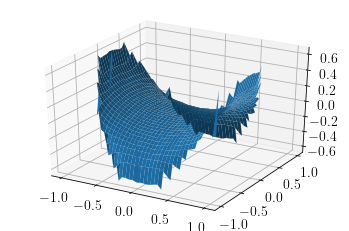

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

In [14]:
fig.dpi = 300
fig.savefig("report/figures/08_mc.png", bbox_inches='tight')

/home/igudav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


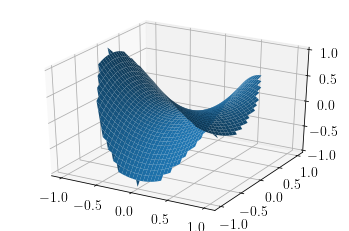

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Z_anal = f(X, Y)
mask = g(X, Y) <= 0
Z_anal[~mask] = np.nan
ax.plot_surface(X, Y, Z_anal)
plt.show()

In [16]:
fig.dpi = 300
fig.savefig("report/figures/08_anal.png", bbox_inches='tight')

/home/igudav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  This is separate from the ipykernel package so we can avoid doing imports until


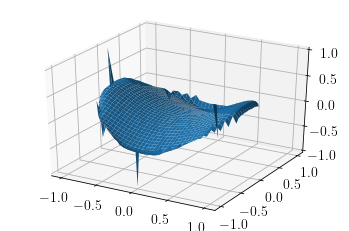

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_anal - Z)
plt.show()

In [18]:
fig.dpi = 300
fig.savefig("report/figures/08_discr.png", bbox_inches='tight')

# Задание 9

## 9.1

### Винеровский процесс

Пусть $t > s$, тогда
$$
k(t, s) = \mathbb{E}[W(t)W(s)] = \mathbb{E}\left[W(s)^2\right] + \mathbb{E}\left[W(s)(W(t) - W(s))\right] = 
\mathbb{E}\left[W(s)^2\right] + \mathbb{E}\left[W(s)\right]\mathbb{E}\left[(W(t) - W(s))\right] = 
\sigma^2 \min(t, s)
$$

Для метода деления отрезка пополам найдем условное распределение $\mathbb{P}(W(t) = x_2 \mid W(t - \Delta t) = x_1, W(t + \Delta t) = x_3)$.
По теореме Байеса и определению условной плотности имеем:
$$
p\left(W(t) = x_2 \mid W(t - \Delta t) = x_1, W(t + \Delta t) = x_3\right) =
\frac{p(W(t + \Delta t) = x_3 | W(t) = x_2) p(W(t) = x_2 | W(t - \Delta t) = x_1)}{p(W(t + \Delta t) = x_3 | W(t - \Delta t) = x_1)} =\\
=\frac{\mathcal{N}(x_3 | x_2, \Delta t \sigma^2)\mathcal{N}(x_2 | x_1, \Delta t \sigma^2)}{\mathcal{N}(x_3 | x_1, 2 \Delta t \sigma^2)} = \mathcal{N}\left(x_2 \biggm| \frac{x_1 + x_3}{2}, \frac{\Delta t \sigma^2}2\right).
$$

### Процесс Орнштейна-Уленбека

Процесс Орнштейна-Уленбека - это стационарный марковский гауссовский процесс. Без ограничения общности рассмотрим центрированный процесс.
Для корреляционной функции такого процесса верны свойства:
$$
\rho(t_1, t_3)) = \rho(t_1, t_2)\rho(t_2, t_3), \quad t_1 < t_2 < t_3, \\
\rho(t, s) = \rho(|t - s|), \quad t < s.
$$
Отсюда $\rho(a + b) = \rho(a)\rho(b)$.
Учитвая то, что корреляционная функция ограничена, получаем, что
$$
\rho(t, s) = \sigma^2e^{-\lambda |t - s|}, \quad \lambda > 0.
$$

Для метода деления отрезка пополам найдем условное распределение $\mathbb{P}(X(t) = x_2 \mid X(t - \Delta t) = x_1, X(t + \Delta t) = x_3)$.
По теореме Байеса и определению условной плотности имеем:
$$
p\left(X(t) = x_2 \mid X(t - \Delta t) = x_1, X(t + \Delta t) = x_3\right) =
\frac{p(X(t + \Delta t) = x_3 | X(t) = x_2) p(X(t) = x_2 | X(t - \Delta t) = x_1)}{p(X(t + \Delta t) = x_3 | X(t - \Delta t) = x_1)} =\\
=\mathcal{N}\left(\frac{x_1 + x_3}{2 \cosh (\lambda \Delta t)}, \sigma^2 \tanh (\lambda \Delta t) \right)
$$


## 9.2

In [53]:
# будем генерировать процесс на отрезке от 0 до 1 с параметрами
# n_div — число разбиений. Размер сетки 2^n_div + 1
def gen_w(n_div, sigma=1):
    
    res = np.zeros(2**n_div + 1)
    res[-1] = sigma * rnd.randn()
    dt = 0.5
    step = start = int(2**(n_div - 1))
    end = int(2**n_div + 1)
    for _ in range(n_div):
        idx = np.arange(start, end, 2 * step)
        res[idx] = 0.5 * (res[idx - step] + res[idx + step]) +\
            sigma * np.sqrt(dt / 2) * rnd.randn(len(idx))
        start //= 2
        step //= 2
        dt /= 2
    return res

In [54]:
def gen_ou(n_div, sigma=1, lam=1):
    
    res = np.zeros(2**n_div + 1)
    res[0] = sigma * rnd.randn()
    res[-1] = sigma * np.sqrt(1 - np.exp(-2 * lam)) * rnd.randn() + res[0] * np.exp(-lam)
    dt = 0.5
    step = start = int(2**(n_div - 1))
    end = int(2**n_div + 1)
    for _ in range(n_div):
        idx = np.arange(start, end, 2 * step)
        res[idx] = (res[idx - step] + res[idx + step]) / (2 * np.cosh(lam * dt)) +\
            sigma * np.sqrt(np.tanh(lam * dt)) * rnd.randn(len(idx))
        start //= 2
        step //= 2
        dt /= 2
    return res

## 9.3

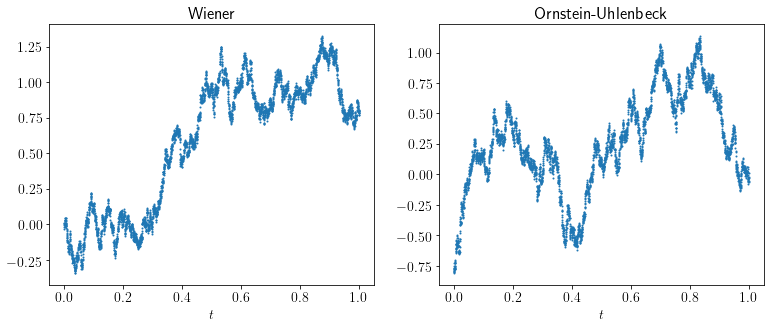

In [57]:
n_div = 12
t = np.linspace(0, 1, 2**n_div + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

ax1.plot(t, gen_w(n_div), '.', ms=2)
ax1.set_title('Wiener')
ax1.set_xlabel(r'$t$')
ax2.plot(t, gen_ou(n_div), '.', ms=2)
ax2.set_title('Ornstein-Uhlenbeck')
ax2.set_xlabel(r'$t$')

plt.show()

In [58]:
fig.dpi = 300
fig.savefig("report/figures/09_proc.png", bbox_inches='tight')

# Задание 10

## 10.1

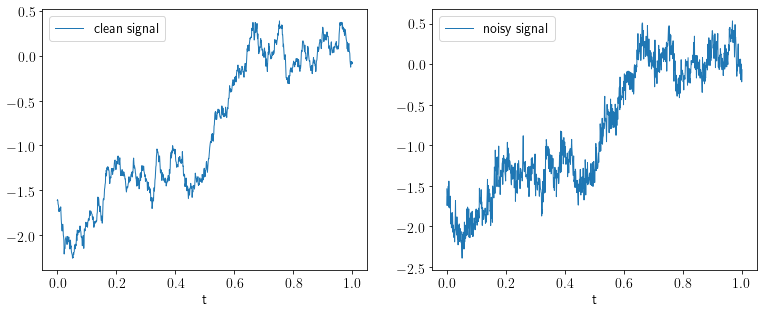

In [35]:
n_div = 10
noise_std = 0.1

x_clean = gen_ou(n_div)
x_noisy = x_clean + noise_std * rnd.randn(2**n_div + 1)
t = np.linspace(0, 1, 2**n_div + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(t, x_clean, label='clean signal', lw=1)
ax1.set_xlabel('t')
ax1.legend()
ax2.plot(t, x_noisy, label='noisy signal', lw=1)
ax2.set_xlabel('t')
ax2.legend()

plt.show()

In [36]:
fig.dpi = 300
fig.savefig("report/figures/10_noisy.png", bbox_inches='tight')

## 10.2

In [37]:
def kalman_filter(signal, sig_a, sig_var, noise_var):
    denoised_sig = np.zeros(signal.size)
    error_var = np.zeros(signal.size)
    denoised_sig[0] = signal[0]
    error_var[0] = noise_var
    
    for i in range(1, signal.size):
        signal_pred = sig_a * denoised_sig[i - 1]
        error_pred = sig_a**2 * error_var[i - 1] + sig_var
        diff = signal[i] - signal_pred
        gain = error_pred / (error_pred + noise_var)
        denoised_sig[i] = signal_pred + gain * diff
        error_var[i] = (1 - gain) * error_pred
    
    return denoised_sig, error_var

In [38]:
dt = 2**(-n_div)
lam = 1
sigma = 1
sig_a = np.exp(-lam * dt)
noise_var = noise_std**2
sig_var = sigma**2 * (1 - np.exp(-2 * lam * dt))

denoised_sig, error_var = kalman_filter(x_noisy, sig_a, sig_var, noise_var)

alpha = 0.05
conf_half_interval = np.sqrt(error_var) * scs.norm.ppf(1 - alpha / 2)

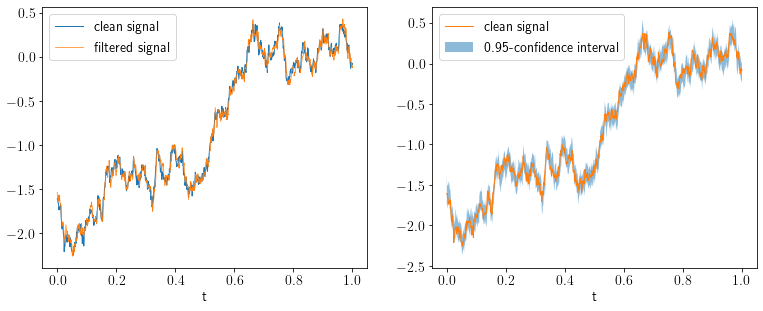

Observations out of the confidence interval: 6.15%


In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

ax1.plot(t, x_clean, label='clean signal', lw=1)
ax1.plot(t, denoised_sig, label='filtered signal', lw=0.7)
ax1.legend()
ax1.set_xlabel('t')

ax2.fill_between(t, denoised_sig + conf_half_interval, denoised_sig - conf_half_interval,
                alpha=0.5, label='{}-confidence interval'.format(1 - alpha))
ax2.plot(t, x_clean, label='clean signal', lw=1, c='C1')
ax2.set_xlabel('t')
ax2.legend()

plt.show()

print('Observations out of the confidence interval: {:.2f}%'.format(
    (np.abs(denoised_sig - x_clean) > conf_half_interval).sum() / denoised_sig.size * 100))

In [40]:
fig.dpi = 300
fig.savefig("report/figures/10_filtered.png", bbox_inches='tight')

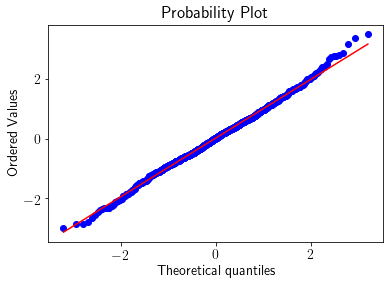

Yeah! Normal error ٩(◕‿◕)۶


In [28]:
fig, ax = plt.subplots()

scs.probplot((x_clean - denoised_sig) / np.sqrt(error_var), fit=False, plot=ax)

plt.show()

print('Yeah! Normal error ٩(◕‿◕)۶')

## 10.3 (теперь Коши)

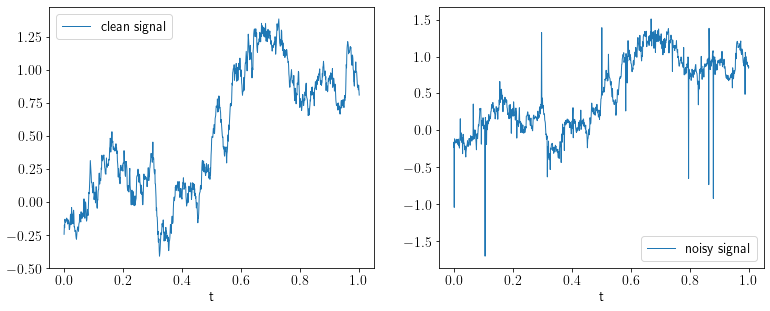

In [46]:
n_div = 10
noise_factor = 0.01

x_clean = gen_ou(n_div)
x_noisy = x_clean + scs.cauchy.rvs(scale=noise_factor, size=2**n_div + 1)
t = np.linspace(0, 1, 2**n_div + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(t, x_clean, label='clean signal', lw=1)
ax1.set_xlabel('t')
ax1.legend()
ax2.plot(t, x_noisy, label='noisy signal', lw=1)
ax2.set_xlabel('t')
ax2.legend()

plt.show()

In [48]:
fig.dpi = 300
fig.savefig("report/figures/10_cnoisy.png", bbox_inches='tight')

In [49]:
dt = 2**(-n_div)
lam = 1
sigma = 1
sig_a = np.exp(-lam * dt)
noise_var = noise_factor
sig_var = sigma**2 * (1 - np.exp(-2 * lam * dt))

denoised_sig, error_var = kalman_filter(x_noisy, sig_a, sig_var, noise_var)

alpha = 0.05
conf_half_interval = np.sqrt(error_var) * scs.norm.ppf(1 - alpha / 2) # некорректно, ну а что делать?

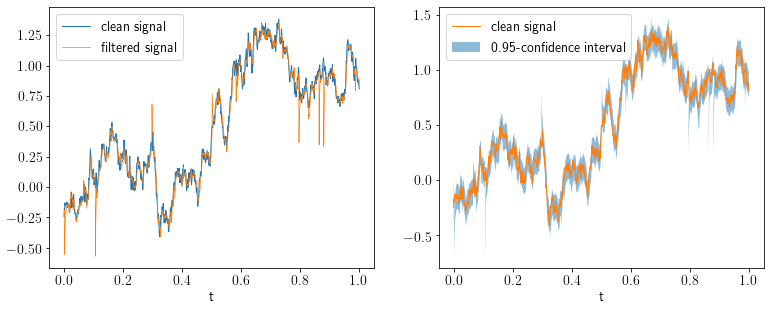

Observations out of the confidence interval: 3.41%


In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

ax1.plot(t, x_clean, label='clean signal', lw=1)
ax1.plot(t, denoised_sig, label='filtered signal', lw=0.7)
ax1.legend()
ax1.set_xlabel('t')

ax2.fill_between(t, denoised_sig + conf_half_interval, denoised_sig - conf_half_interval,
                alpha=0.5, label='{}-confidence interval'.format(1 - alpha))
ax2.plot(t, x_clean, label='clean signal', lw=1, c='C1')
ax2.set_xlabel('t')
ax2.legend()

plt.show()

print('Observations out of the confidence interval: {:.2f}%'.format(
    (np.abs(denoised_sig - x_clean) > conf_half_interval).sum() / denoised_sig.size * 100))

In [52]:
fig.dpi = 300
fig.savefig("report/figures/10_cfiltered.png", bbox_inches='tight')

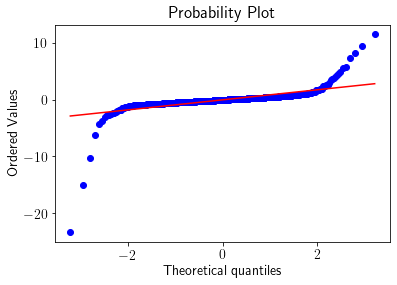

Oops! That tails! Seems to be abnormal ヽ(ﾟ〇ﾟ)ﾉ


In [32]:
fig, ax = plt.subplots()

scs.probplot((x_clean - denoised_sig) / np.sqrt(noise_factor), fit=False, plot=ax)

plt.show()

print('Oops! That tails! Seems to be abnormal ヽ(ﾟ〇ﾟ)ﾉ')

# Задание 11

## 11.1 (СМО)

Промоделируем СМО на отрезке $[0, T]$.
Пусть $\tau_1, \ldots, \tau_N$ — времена поступления заявок.
Из свойств Пуассоновского процесса заключаем, что $\mathbb{E}N = \lambda T$,
и $\tau_1,\ldots,\tau_N$ при фиксированном $N$ представляет собой вариационный ряд равномерного распределения на отрезке $[0, T]$.

In [59]:
def pois_proc(lam, T):
    n_points = rnd.poisson(lam * T)
    return np.sort(rnd.rand(n_points) * T)

In [60]:
def simulate_queue(t_requests, dur_responses, T):
    
    queue = list(zip(t_requests, np.ones_like(t_requests).astype(int)))
    heapq.heapify(queue)
    dur_responses = iter(dur_responses)
    cur_t = 0
    last_resp_t = -1
    cur_status = 0
    queue_status = np.zeros(1)
    queue_times = np.zeros(1)
    
    while cur_t < T and len(queue) > 0:
        cur_t, d = heapq.heappop(queue)
        last_resp_t = max(cur_t, last_resp_t)
        cur_status += d
        queue_times = np.append(queue_times, cur_t)
        queue_status = np.append(queue_status, cur_status)
        if d > 0:
            last_resp_t += next(dur_responses)
            heapq.heappush(queue, (last_resp_t, -1))
    
    idx = queue_times <= T
    return queue_times[idx], queue_status[idx]

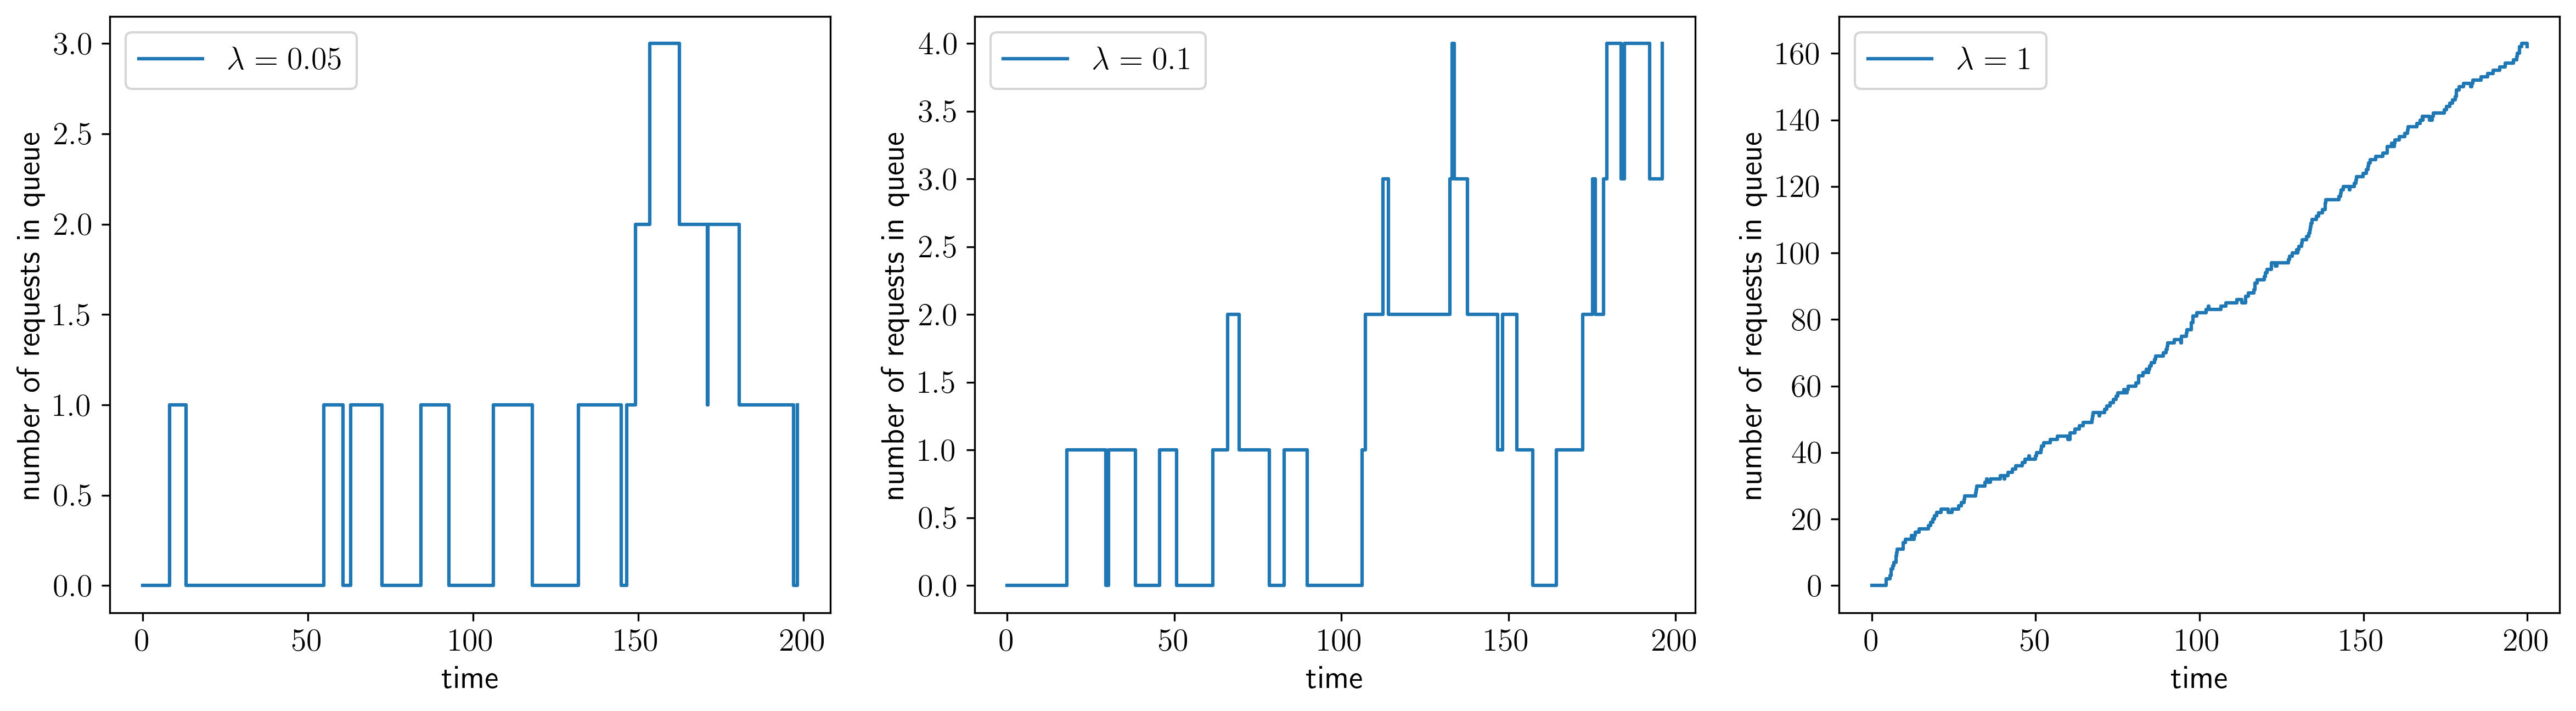

In [72]:
T = 200
lambdas = [0.05, 0.1, 1]
fig, ax_list = plt.subplots(1, 3, figsize=(19.2, 4.8))
fig.dpi = 300

for i in range(3):
    t_requests = pois_proc(lambdas[i], T)
    dur_responses = scs.chi2.rvs(10, size=t_requests.size)
    
    queue_times, queue_status = simulate_queue(t_requests, dur_responses, T)
    
    
    ax_list[i].step(queue_times, queue_status, where='post', label='$\lambda={}$'.format(lambdas[i]))
    ax_list[i].set_xlabel('time')
    ax_list[i].set_ylabel('number of requests in queue')
    ax_list[i].legend()

plt.show()

In [73]:
fig.dpi = 300
fig.savefig("report/figures/11_vanilla.png", bbox_inches='tight')

## 11.2

Циклическая активность описывается функцией интенсивности $\lambda(t) = \lambda(1 + \cos t)$.
Заметим, что $\forall t\ \lambda(t) \leqslant 2\lambda$.
Для моделирования искомого процесса Смоделируем процесс с интенсивностью $2\lambda$, 
а затем скачок в момент времени $t$ оставим с вероятностью $\frac{\lambda(t)}{2\lambda}$.

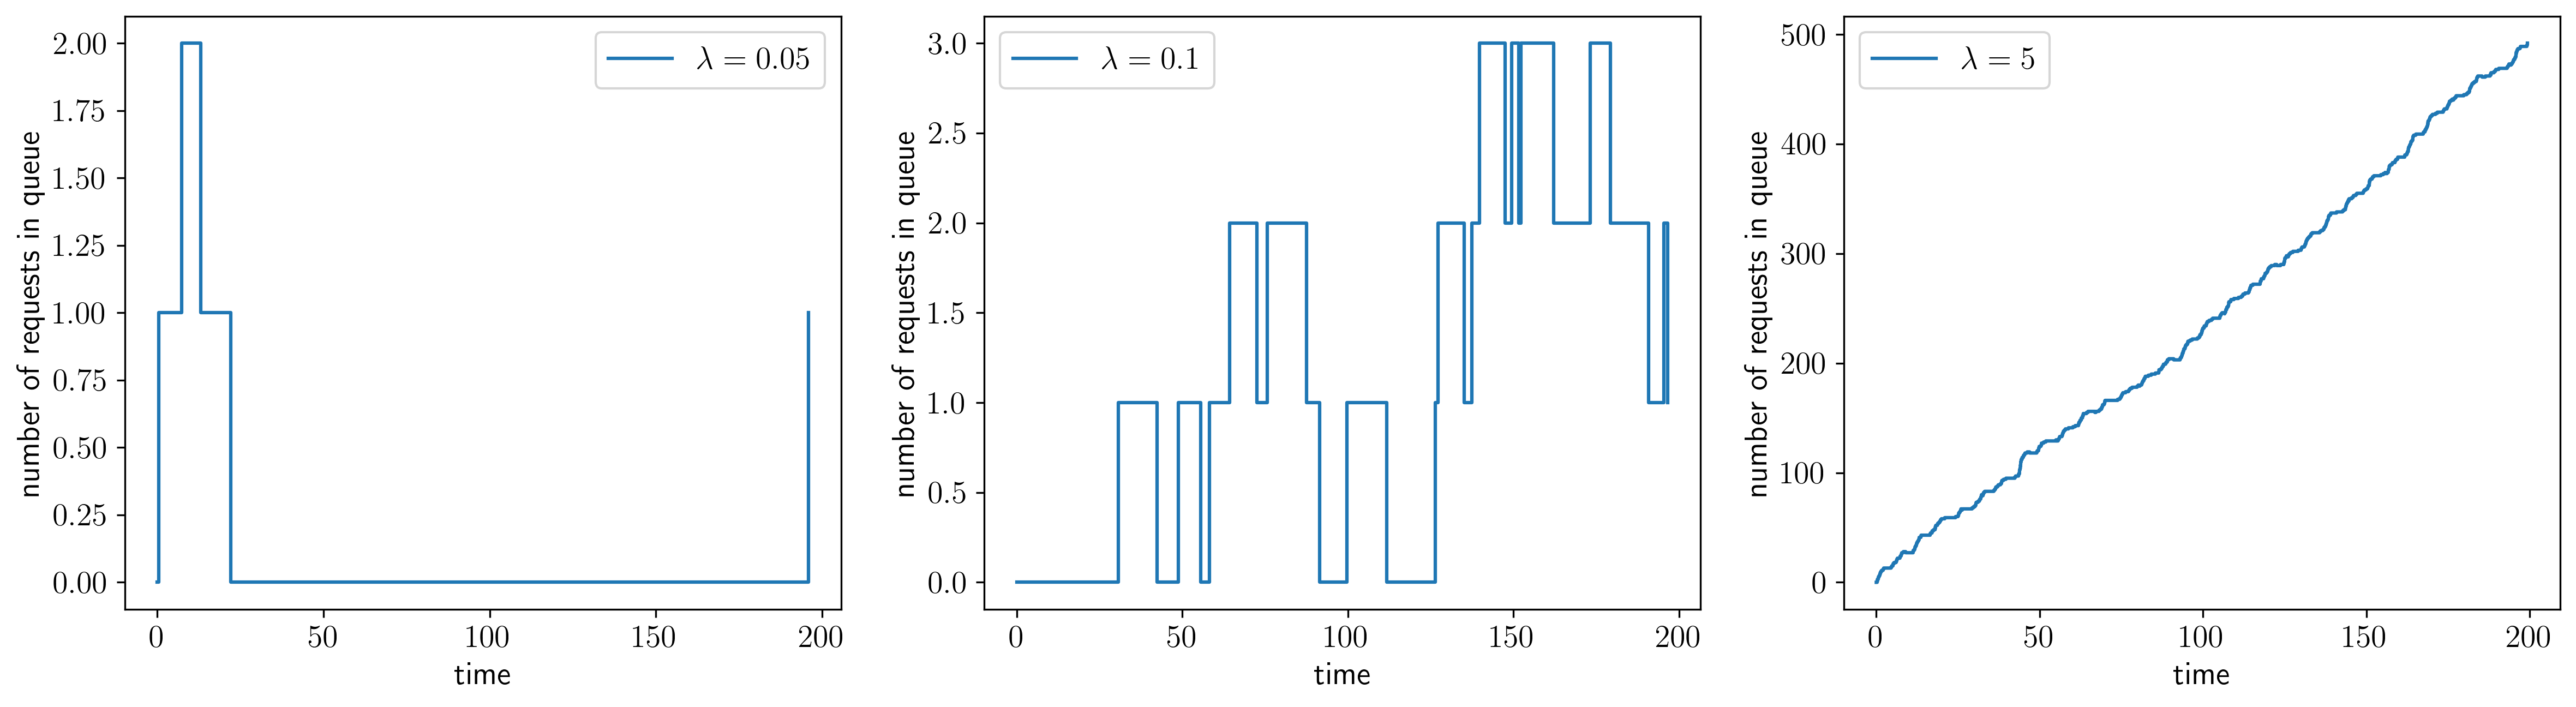

In [74]:
lambdas = [0.05, 0.1, 5]
fig, ax_list = plt.subplots(1, 3, figsize=(19.2, 4.8))
fig.dpi = 300

for i in range(3):
    t_requests = pois_proc(lambdas[i], T)
    t_requests = t_requests[rnd.rand(t_requests.size) < lam * (1 + np.cos(t_requests)) / (2 * lam)]
    dur_responses = scs.chi2.rvs(10, size=t_requests.size)
    
    queue_times, queue_status = simulate_queue(t_requests, dur_responses, T)
    
    
    ax_list[i].step(queue_times, queue_status, where='post', label='$\lambda={}$'.format(lambdas[i]))
    ax_list[i].set_xlabel('time')
    ax_list[i].set_ylabel('number of requests in queue')
    ax_list[i].legend()

plt.show()

In [75]:
fig.dpi = 300
fig.savefig("report/figures/11_cyclic.png", bbox_inches='tight')

## 11.3

Процесс имеет вид:
$$
X(t) = W + ct - \sum\limits_{n=0}^{N(t)} \xi_n,
$$
где $N(t)$ — пуассоновский процесс, а $\xi_n$ имеет распределение Парето с показателем $b$.
Тогда $\mathbb{E}\xi_n = b / (b - 1)$ и $\mathbb{E} X(t) = W + ct +\lambda t b / (b - 1)$.
Соответственно, критическое значение $b^* = c / (c - \lambda)$.
Если хвост тяжелее, то капитал скорее будет расти, если легче, то убывать.

In [76]:
def simulate_insurance(t_requests, money_requests, c, W):
    t = np.append(np.zeros(1), np.repeat(t_requests, 2))
    pnl = np.zeros_like(t)
    dt = np.diff(t_requests, prepend=0)
    pnl[1::2] = c * dt
    pnl[2::2] = -money_requests
    X = W + np.cumsum(pnl)
    bankruptcy = np.argmax(X < 0)
    if bankruptcy > 0:
        X[bankruptcy:] = 0
    return t, X

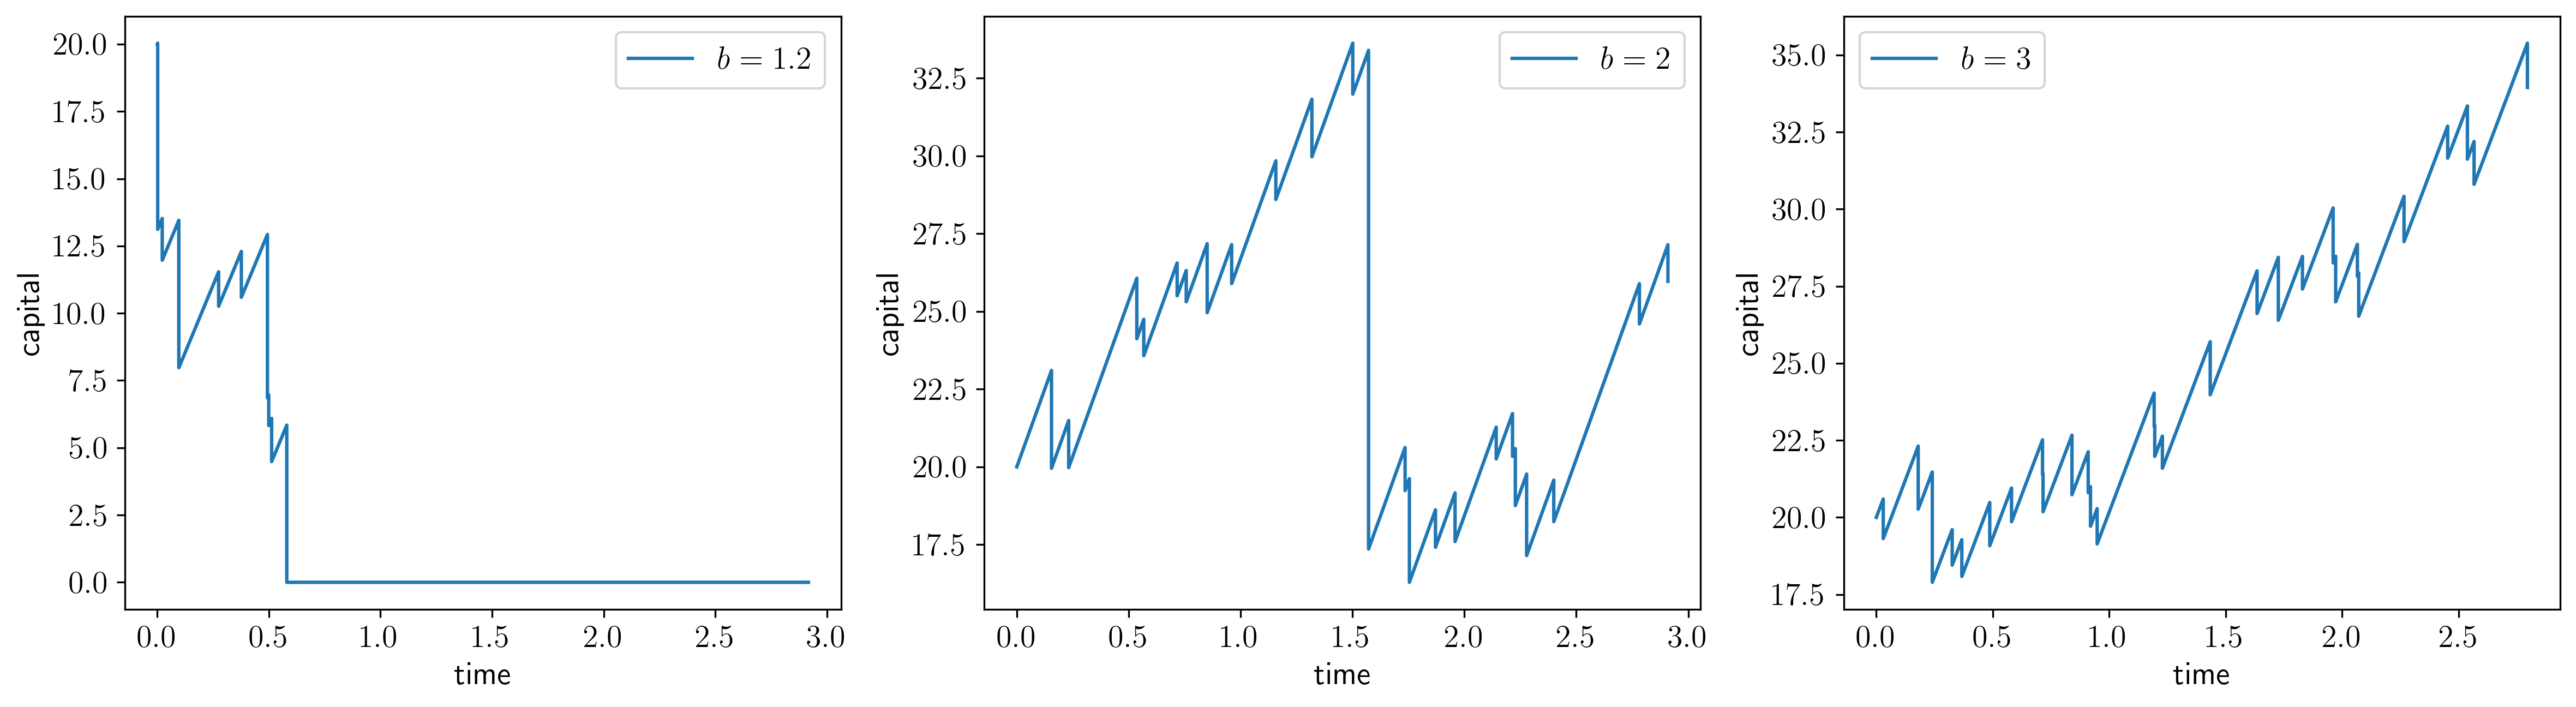

In [78]:
T = 3
lam = 10
W = 20
c = 20
b = [1.2, 2, 3]
fig, ax = plt.subplots(1, 3, figsize=(19.2, 4.8))
fig.dpi = 300

for i in range(3):
    t_requests = pois_proc(lam, T)
    money_requests = scs.pareto.rvs(b[i], size=t_requests.size)
    
    t, x = simulate_insurance(t_requests, money_requests, c, W)
    
    ax[i].plot(t, x, label='$b = {}$'.format(b[i]))
    ax[i].set_xlabel('time')
    ax[i].set_ylabel('capital')
    ax[i].legend()

In [79]:
fig.dpi = 300
fig.savefig("report/figures/11_insur.png", bbox_inches='tight')